In [3]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]

# 3 random rows
(df.sample(3))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
11865,60,Private,82388,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,38,United-States,<=50K
11540,42,Private,66460,Some-college,10,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,<=50K
689,22,Local-gov,198478,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K.


In [16]:
# shape of dataset

df.shape

(48842, 15)

AttributeError: 'AxesSubplot' object has no attribute 'is_first_col'

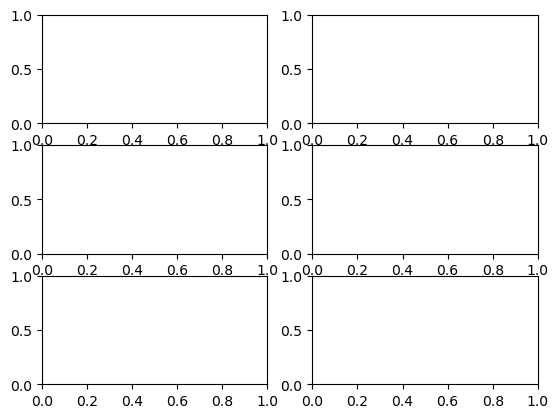